In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# 1) Load data
df = pd.read_csv("manufacturing_yield_overfit_regularization.csv") #this data has many correlated sensor channels, only a few truly informative
X = df.drop(columns=["yield"])
y = df["yield"]

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)

# 3) Models (scale features for fair/standard regularization)
ols = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=np.logspace(-4, 6, 120), cv=5))
])

lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LassoCV(alphas=np.logspace(-4, 2, 120), cv=5,
                      random_state=42, max_iter=120000))
])

# 4) Evaluate
def eval_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        "Model": name,
        "Test_MSE": mean_squared_error(y_test, pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, pred)),
        "Test_R2": r2_score(y_test, pred),
    }

results = pd.DataFrame([
    eval_model("OLS", ols),
    eval_model("RidgeCV", ridge),
    eval_model("LassoCV", lasso),
]).sort_values("Test_MSE")

results


,Model,Test_MSE,Test_RMSE,Test_R2
2,LassoCV,36.454765,6.037778,0.176461
1,RidgeCV,41.252701,6.422827,0.068072
0,OLS,421.854183,20.539089,-8.529984


In [2]:
# Selected alphas
print("Ridge alpha:", ridge.named_steps["model"].alpha_)
print("Lasso alpha:", lasso.named_steps["model"].alpha_)

# How many features Lasso kept?
nonzero = np.sum(lasso.named_steps["model"].coef_ != 0)
print(f"Lasso nonzero coefficients: {nonzero} / {X.shape[1]}")


Ridge alpha: 200.68781676649706
Lasso alpha: 0.47937156455582186
Lasso nonzero coefficients: 11 / 103


In [5]:
# Fit models again + generate predictions

ols.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

ols_pred = ols.predict(X_test)
ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)


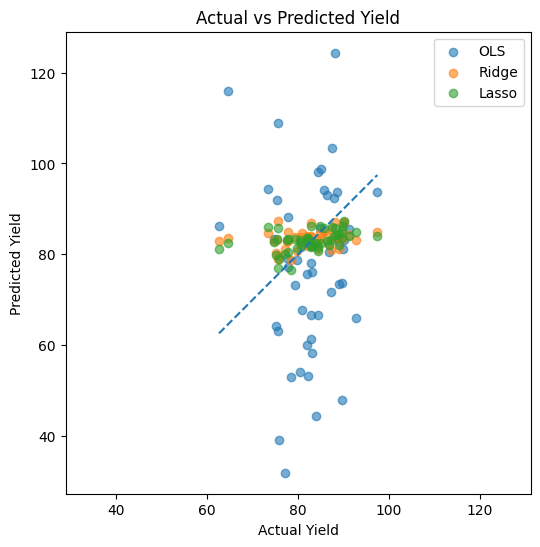

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

plt.scatter(y_test, ols_pred, label="OLS", alpha=0.6)
plt.scatter(y_test, ridge_pred, label="Ridge", alpha=0.6)
plt.scatter(y_test, lasso_pred, label="Lasso", alpha=0.6)

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.axis("equal")   # <-- IMPORTANT, force diagonal line

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.legend()
plt.title("Actual vs Predicted Yield")

plt.show()



In [ ]:
# Ridge/Lasso points are horizontally spread because the actual yields vary across test samples.
# That has NOTHING to do with the model.It’s simply the dataset.
# For many different actual yields, the model predicts similar values.
# Ridge/Lasso are pulling predictions toward the mean yield. This is classic regularization behavior.
# They prefer: stable predictions, smaller coefficients, less extreme outputs
# Instead of chasing every fluctuation.

In [8]:
# Coefficient table for OLS vs Ridge vs Lasso (with scaling)
# Assumes: X is a DataFrame, and you already fit: ols, ridge, lasso (all Pipelines with StandardScaler)

import pandas as pd
import numpy as np

# --- Safety: fit if you haven't already ---
# ols.fit(X_train, y_train)
# ridge.fit(X_train, y_train)
# lasso.fit(X_train, y_train)

coef_df = pd.DataFrame({
    "feature": X.columns,
    "OLS_coef (stdX)":   ols.named_steps["model"].coef_,
    "Ridge_coef (stdX)": ridge.named_steps["model"].coef_,
    "Lasso_coef (stdX)": lasso.named_steps["model"].coef_,
})

# Add magnitudes for sorting/inspection
coef_df["|OLS|"]   = coef_df["OLS_coef (stdX)"].abs()
coef_df["|Ridge|"] = coef_df["Ridge_coef (stdX)"].abs()
coef_df["|Lasso|"] = coef_df["Lasso_coef (stdX)"].abs()

# Sort by Lasso magnitude (often most interpretable due to sparsity)
coef_df = coef_df.sort_values("|Lasso|", ascending=False)

# Pretty print (no scientific explosion)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x: .6f}")

coef_df.head(30)


,feature,OLS_coef (stdX),Ridge_coef (stdX),Lasso_coef (stdX),|OLS|,|Ridge|,|Lasso|
30,sensor_g4_6,3.866627,0.335134,1.605849,3.866627,0.335134,1.605849
4,defects,-4.798363,-0.387519,-0.909256,4.798363,0.387519,0.909256
51,sensor_g8_3,-8.331094,-0.267146,-0.859381,8.331094,0.267146,0.859381
39,sensor_g6_3,-2.098032,-0.143368,-0.408738,2.098032,0.143368,0.408738
1,pressure,-1.386169,-0.209432,-0.390288,1.386169,0.209432,0.390288
5,tool_age,-1.804091,-0.220955,-0.385857,1.804091,0.220955,0.385857
0,temp,2.027127,0.204441,0.301714,2.027127,0.204441,0.301714
40,sensor_g6_4,3.496342,-0.165830,-0.270163,3.496342,0.165830,0.270163
21,sensor_g3_3,-1.248049,-0.117192,-0.217266,1.248049,0.117192,0.217266
63,sensor_g10_3,8.735469,0.116381,0.136765,8.735469,0.116381,0.136765


In [9]:
# Show which features Lasso actually selected (non-zero coefficients)

selected = coef_df[coef_df["Lasso_coef (stdX)"] != 0].copy()
selected[["feature", "OLS_coef (stdX)", "Ridge_coef (stdX)", "Lasso_coef (stdX)"]].head(50)


,feature,OLS_coef (stdX),Ridge_coef (stdX),Lasso_coef (stdX)
30,sensor_g4_6,3.866627,0.335134,1.605849
4,defects,-4.798363,-0.387519,-0.909256
51,sensor_g8_3,-8.331094,-0.267146,-0.859381
39,sensor_g6_3,-2.098032,-0.143368,-0.408738
1,pressure,-1.386169,-0.209432,-0.390288
5,tool_age,-1.804091,-0.220955,-0.385857
0,temp,2.027127,0.204441,0.301714
40,sensor_g6_4,3.496342,-0.165830,-0.270163
21,sensor_g3_3,-1.248049,-0.117192,-0.217266
63,sensor_g10_3,8.735469,0.116381,0.136765


In [ ]:
#Ridge penalty grows smoothly, it make everything small
# But: it never forces anything to zero. It just reduces magnitudes
# Result: Ridge keeps all features, but weak ones get tiny weights.
#Ridge constraint (circle): Smooth boundary → intersection rarely hits axes → coefficients ≠ 0.
# 
#Lasso penalty has sharp corner at zero. 
# It literally encourages coefficients to land exactly at zero.
# Result: Lasso performs automatic feature selection.
#Lasso constraint (diamond): Sharp corners on axes → intersection often lands on axes → zeros.

In [10]:
# Count how many features Lasso kept
n_nonzero = int(np.sum(lasso.named_steps["model"].coef_ != 0))
print(f"Lasso kept {n_nonzero} / {X.shape[1]} features")



Lasso kept 11 / 103 features
